In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from src.emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)
from src.forest_generator import generate_random_graph

#### Visualization

In [2]:
TEX_PLOTS = False

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

# Results Random network

### Initialization of the network.

In [3]:
G = generate_random_graph(200, p=0.5)

In [4]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

#Rename the quantities of interest
roots_carbon, plant_carbon, plant_diameter = z[:N, :], z[N:2*N, :], z[2*N:3*N, :] 

In [5]:
nodes_by_cohort = {"Sapling": [], "Maturing": [], "Established": []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)

### Group information

Cohort Sapling grew on average 19.76 cm
Cohort Sapling grew on average 200045.48% +- 783524.59

 #### Sapling statistics #######
Sapling competition between samplings (std growth percentage) 783524.59%
10 out of the 17 Saplings were successful. That is 58.82%


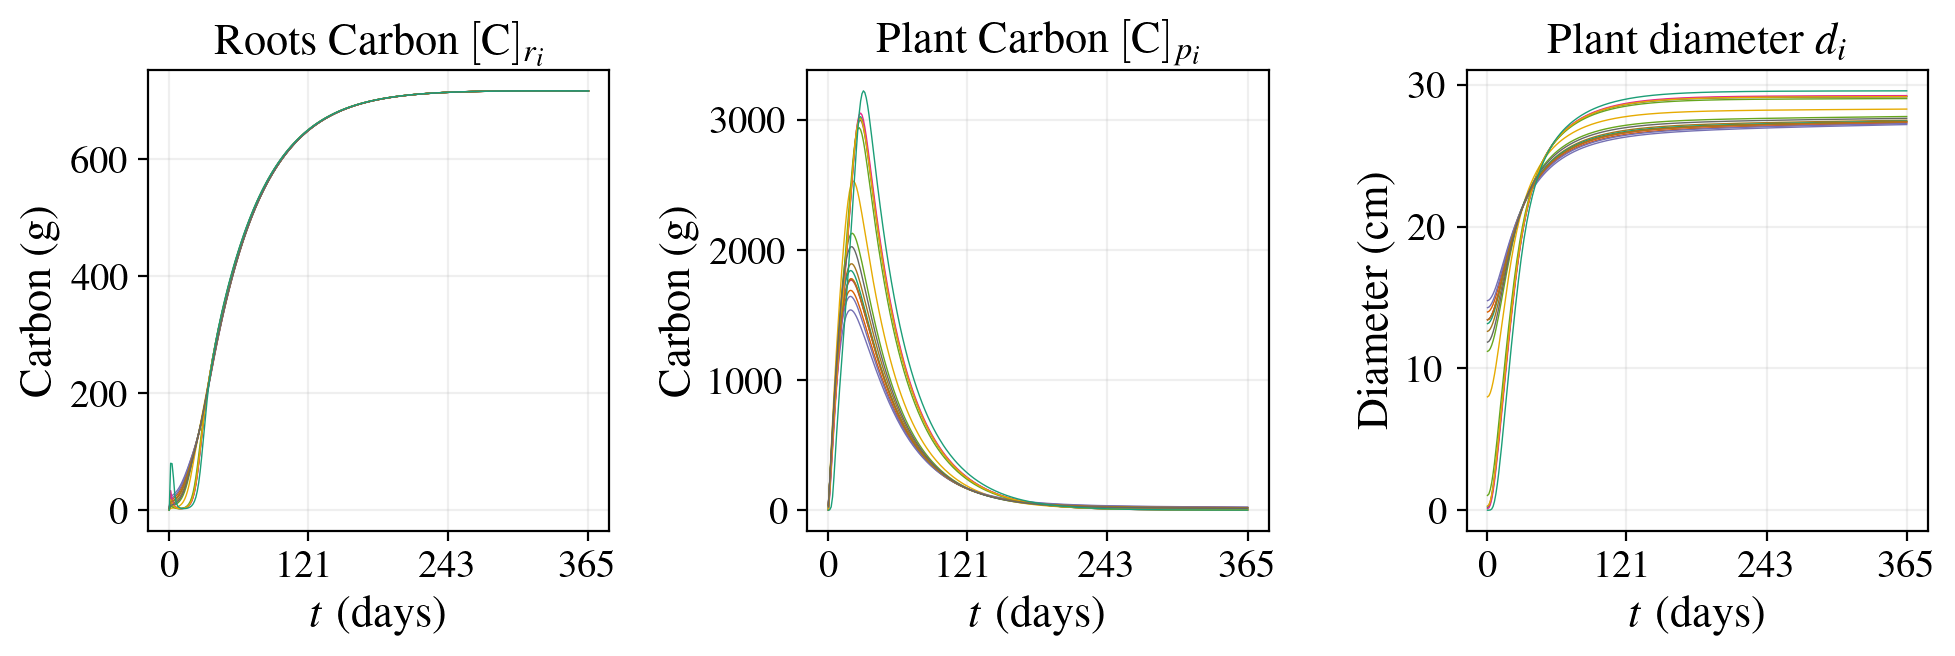

Cohort Maturing grew on average 4.31 cm
Cohort Maturing grew on average 122.79% +- 24.16


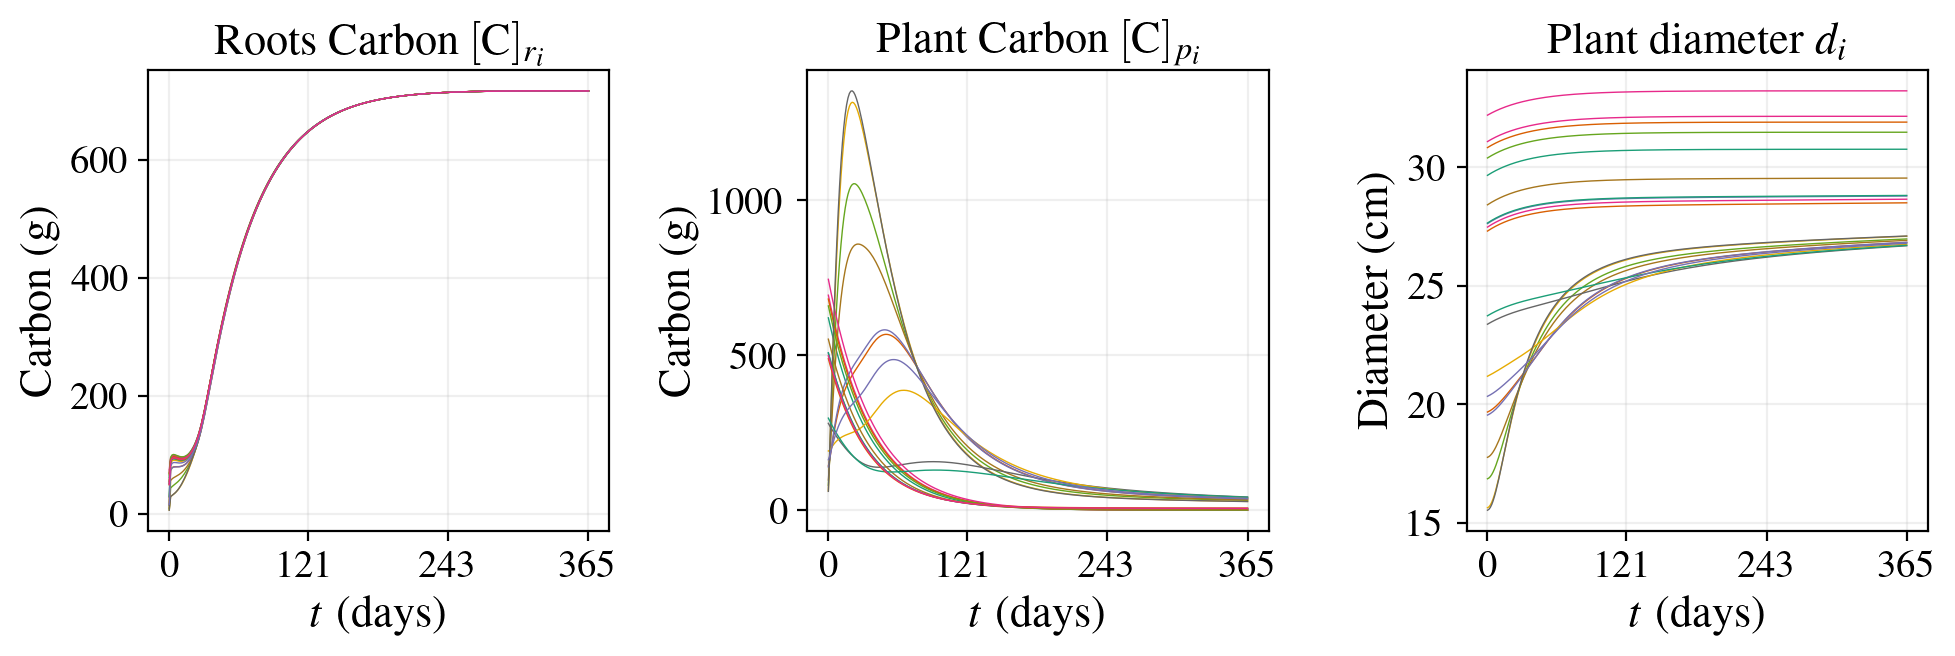

Cohort Established grew on average 0.06 cm
Cohort Established grew on average 100.13% +- 0.39


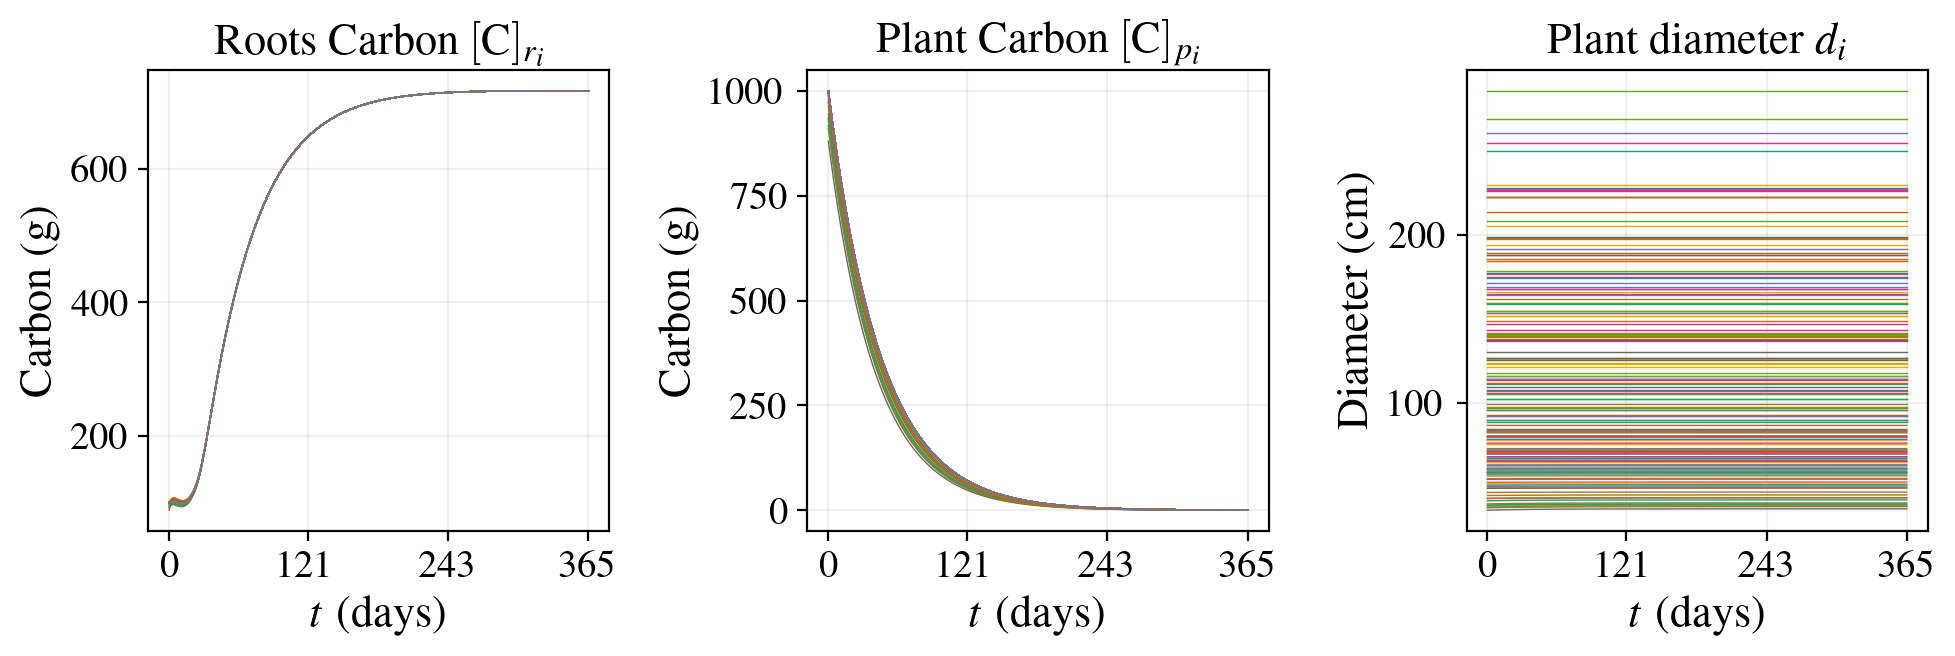

In [6]:
ONE_YEAR = 16_000 # time steps equal to one year

t_in_days = (t/t_range[1])*(365./(ONE_YEAR/t_range[1]))

for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #Calculate Average growth
    growth = plant_diameter[node_idxs, -1] - plant_diameter[node_idxs, 0]
    avg_growth = np.mean(growth)
    
    #Calculate growth in percantages
    percentages = plant_diameter[node_idxs, -1]/plant_diameter[node_idxs, 0]*100
    percentage_mean = np.mean(percentages)
    percentage_stdev = np.std(percentages)


    print(f"Cohort {str(cohort)} grew on average {avg_growth:.2f} cm")
    print(f"Cohort {str(cohort)} grew on average {percentage_mean:.2f}% +- {percentage_stdev:.2f}")
    
    if cohort == "Sapling": 
        success_threshold = np.max(growth)/2
        n_successes =  np.sum([growth >= success_threshold])     #np.sum([percentages >= 200])
        print("\n #### Sapling statistics #######")
        print(f"Sapling competition between samplings (std growth percentage) {percentage_stdev:.2f}%")
        print(f"{n_successes} out of the {len(percentages)} Saplings were successful. That is {n_successes/len(percentages)*100:.2f}%")

        
    #print(percentages)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

    axes[0].set_title(r"Roots Carbon $[\text{C}]_{r_i}$")
    axes[0].plot(t_in_days, roots_carbon[node_idxs, :].T, linewidth=0.5)
    axes[0].set_xlabel("$t$ (days)")
    axes[0].set_ylabel("Carbon (g)")

    axes[1].set_title(r"Plant Carbon $[\text{C}]_{p_i}$")
    axes[1].plot(t_in_days, plant_carbon[node_idxs, :].T, linewidth=0.5)
    axes[1].set_xlabel("$t$ (days)")
    axes[1].set_ylabel("Carbon (g)")

    axes[2].set_title(r"Plant diameter $d_i$")
    axes[2].plot(t_in_days, plant_diameter[node_idxs, :].T, linewidth=0.5)
    axes[2].set_xlabel("$t$ (days)")
    axes[2].set_ylabel("Diameter (cm)")
    
    for ax in axes:
        ax.set_xlabel("$t$ (days)")
        ax.set_xticks(np.linspace(0, t_in_days[-1], 4, dtype=int))

    plt.tight_layout()
    plt.show()

### Nutrient flows

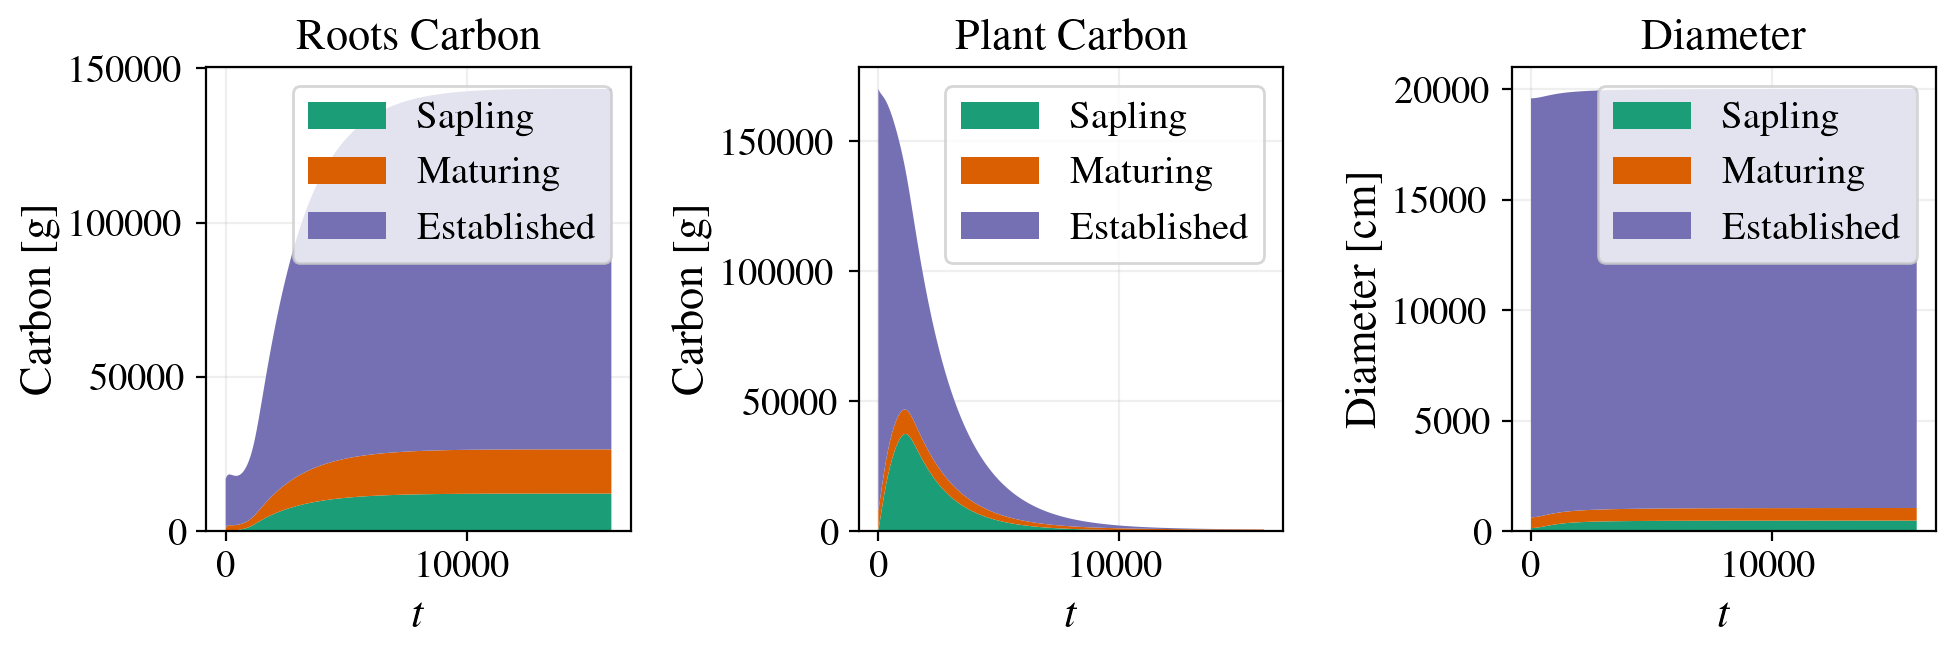

In [7]:
roots_carbon_per_cohort = {}
plant_carbon_per_cohort = {}
plant_diameter_per_cohort = {}


for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #not sure if total diameter makes sense, but currently included to show growth. 
    total_diameter = np.sum(plant_diameter[node_idxs, :], axis = 0)
    total_plant_carbon = np.sum(plant_carbon[node_idxs, :], axis = 0)
    totaL_root_carbon  = np.sum(roots_carbon[node_idxs, :], axis = 0)
    
    roots_carbon_per_cohort[cohort] = totaL_root_carbon
    plant_carbon_per_cohort[cohort] = total_plant_carbon
    plant_diameter_per_cohort[cohort] = total_diameter
    

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

axes[0].set_title("Roots Carbon")
axes[0].stackplot(t, np.array(list(roots_carbon_per_cohort.values())))
axes[0].legend(labels = np.array(list(roots_carbon_per_cohort.keys())))
axes[0].set_ylabel("Carbon [g]")
axes[0].set_xlabel("$t$")


axes[1].set_title("Plant Carbon")
axes[1].stackplot(t, np.array(list(plant_carbon_per_cohort.values())))
axes[1].legend(labels = np.array(list(plant_carbon_per_cohort.keys())))
axes[1].set_ylabel("Carbon [g]")
axes[1].set_xlabel("$t$")


axes[2].set_title("Diameter")
axes[2].stackplot(t, np.array(list(plant_diameter_per_cohort.values())))
axes[2].legend(labels = np.array(list(plant_diameter_per_cohort.keys())))
axes[2].set_ylabel("Diameter [cm]")
axes[2].set_xlabel("$t$")

 
plt.tight_layout()
plt.show()